# RSNA Pneumonia Detection Challenge (2018) Dataset using Detectron2

# Install Detectron

In [2]:
install = False
if install:
    # install dependencies: (use cu101 because colab has CUDA 10.1)
    !pip install -U torch torchvision -f https://download.pytorch.org/whl/cu101/torch_stable.html 
    #!pip3 install -U torch torchvision -f https://download.pytorch.org/whl/cpu/torch_stable.html 
    !pip install cython pyyaml
    !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    import torch, torchvision
    print(torch.__version__, torch.cuda.is_available())
    !gcc --version
    # install detectron2:
    !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
    #!pip3 install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/index.html

## Preliminaries

In [1]:
import pandas as pd
import numpy as np
import glob
import json
import os
import ast
import torch
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.layers import nms
from detectron2.modeling import build_model
from detectron2.structures import image_list
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import ImageList, image_list
from detectron2.layers import batched_nms
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [2]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
from datetime import datetime
dt_string = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")# dd/mm/YY H:M:S
setup_logger(os.path.join("output/", dt_string+'.log'))

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

## Load Data

For this to work you need to have the following datasets:
 - Object Detection training dataset (containing images + bbox):
	 - NIH CXR Dataset: https://nihcc.app.box.com/v/ChestXray-NIHCC
	 - RSNA: https://www.rsna.org/en/education/ai-resources-and-training/ai-image-challenge/RSNA-Pneumonia-Detection-Challenge-2018
		 - [Annotations used in the Pneumonia Challenge](https://s3.amazonaws.com/east1.public.rsna.org/AI/2018/pneumonia-challenge-annotations-adjudicated-kaggle_2018.json)
		 - [Mapping of RSNA image dataset to original NIH dataset](https://s3.amazonaws.com/east1.public.rsna.org/AI/2018/pneumonia-challenge-dataset-mappings_2018.json)
 - Testing Dataset (for embracing transformer), contains images + text
   (no bbox):
	 - MIMIC-CXR-JPG: https://physionet.org/content/mimic-cxr-jpg/2.0.0/
	 - MIMIC-CXR (reports): https://physionet.org/content/mimic-cxr/2.0.0/


### Data Constructor for Detectron2 input

In [3]:
class RSNA_pneumonia:
    '''
    Take in mapping for NIH CXR dataset and annotations from RSNA, merge the two by "StudyInstanceUID" and extract the bounding boxes
    Once bounding boxes have been extracted remove duplicates and set the label. Remove any that dont have bounding boxes
    
    Output: this class will output the same as the input for Detectron2: https://detectron2.readthedocs.io/tutorials/models.html#model-input-format
    '''
    def __init__(self, loc, mappings, annotations, test_perc = 0.2, seed = None, data = None):
        self.loc = loc
        self.mappings = self.__open_file(loc+mappings)
        self.annotations = self.__open_file(loc+annotations)
        self.mapping_df = pd.DataFrame(self.mappings)
        if data is not None:#Load from csv
            self.merged = data
        else:
            self.annotation_df = pd.DataFrame(self.annotations['datasets'][0]['annotations'])
            self.annotation_df = self.annotation_df.groupby('StudyInstanceUID')['data'].apply(list).reset_index()#group by study id and extract the 
            self.merged = pd.merge(self.mapping_df, self.annotation_df , on= 'StudyInstanceUID')
            self.merged[['data', 'pnumonia']] = self.merged.apply(self.fix_data, axis=1)#remove dups and label if pnumonia == True
            self.merged = self.merged[self.merged['pnumonia'] == True]#drop records that dont have pnumonia
            if seed:#set seed for same results
                np.random.seed(seed)
            self.merged['train'] = np.asarray(np.random.rand(len(self.merged)) > test_perc, dtype=int)#randomly split into train and test
    def __open_file(self,file):
        with open(file) as json_file:
            return json.load(json_file)
    def get_dataset(self):
        if len(self.merged) > 0:
            return self.merged
        else:
            print ('You have not initialized ther dataset yet')#How did you get here?
            return None
    #function to generate our dataset dict as per: https://detectron2.readthedocs.io/tutorials/datasets.html
    def bbox2dict(self, x):#multiple rows
        #get all boundingboxes to list[list[float]]
        annotations = []
        for b in x['data']:#for each annotation
            box = [b['x'], b['y'], b['width'], b['height']]#get the bounding box
            annotation = {
            'bbox': box,
            'bbox_mode': BoxMode.XYWH_ABS,
            'category_id': 0, #x['pnumonia'],
            #empty segmentation annotation
            'segmentation': [[box[0], box[1], box[0], box[1] + box[3], box[0] + box[2], box[1] + box[3], box[0] + box[2], box[1]]]
            }
            annotations.append(annotation)
        return annotations#return list of annotations
    def get_nih_cxr_dicts(self, split):#split 1 == train set, 0 == test set
        data = self.merged[self.merged['train'] == split].copy()#get data from object
        all_image_paths = {os.path.basename(x): x for x in glob.glob(os.path.join(self.loc, 'images/', '*.png'))}
        data['path'] = data['img_id'].map(all_image_paths.get)
        data['annotations'] = data.apply(self.bbox2dict, axis=1)
        pre_dic = data[['path','annotations', 'img_id']].copy()#copy over path and annotations
        pre_dic.rename(columns={'path':'file_name','img_id':'image_id'}, inplace=True)
        pre_dic['height'] = 1024#this is the size for the nih dataset, subject to change
        pre_dic['width'] = 1024
        dataset_dicts = pre_dic.to_dict('records')
        return dataset_dicts
    def fix_data(self, x):
        data = x['data']
        tmp = []
        for el in data:
            if type(el) == dict:#we have an annotation
                tmp.append(el)
        tmp = [dict(t) for t in {tuple(d.items()) for d in tmp}]#remove duplicate
        return pd.Series([tmp, len(tmp)>0],index=['data','pnumonia'])#returns the list and whether it has pnumonia

### Load our data

In [3]:
LOAD_FROM_DISK = True

In [5]:
loc = '/home/kl533/krauthammer_partition/NIH_Chest_X_ray_dataset/'
mappings = 'pneumonia-challenge-dataset-mappings_2018.json'
annotations = 'pneumonia-challenge-annotations-adjudicated-kaggle_2018.json'
if LOAD_FROM_DISK:
    merged_csv = pd.read_csv('merged.csv')
    merged_csv['data'] = merged_csv['data'].apply(lambda x: ast.literal_eval(x))
else:
    merged_csv = None
RSNA = RSNA_pneumonia(loc, mappings, annotations, data=merged_csv)#can read from merged CSV otherwise must save it using: #RSNA.merged.to_csv('merged.csv')

### Create our dataset catalogue

In [5]:
for k,v in {'TRAIN':1, 'TEST':0}.items():
    DatasetCatalog.register("RSNA_CXR_{}".format(k), lambda split=v: RSNA.get_nih_cxr_dicts(split))
    MetadataCatalog.get("RSNA_CXR_{}".format(k)).set(thing_classes=['pnumonia'])#1 class pnumonia
NIH_metadata = MetadataCatalog.get("RSNA_CXR_TRAIN")

In [5]:
#DatasetCatalog.clear()

### Visualize data

In [6]:
dataset_dicts = RSNA.get_nih_cxr_dicts(0)#Test SET
dataset_dicts[50]

{'file_name': '/home/kl533/krauthammer_partition/NIH_Chest_X_ray_dataset/images/00026785_020.png',
 'annotations': [{'bbox': [584.27131, 571.60037, 263.74339, 129.52525],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0,
   'segmentation': [[584.27131,
     571.60037,
     584.27131,
     701.12562,
     848.0147,
     701.12562,
     848.0147,
     571.60037]]},
  {'bbox': [587.76682, 572.84305, 281.25557, 128.57393],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0,
   'segmentation': [[587.76682,
     572.84305,
     587.76682,
     701.41698,
     869.0223900000001,
     701.41698,
     869.0223900000001,
     572.84305]]},
  {'bbox': [588, 573, 260, 128],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0,
   'segmentation': [[588, 573, 588, 701, 848, 701, 848, 573]]},
  {'bbox': [550.13629, 475.89223, 328.62123, 321.31852],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0,
   'segmentation': [[550.13629,
     475.89223,
     550.13629,
     7

<Figure size 1080x1080 with 0 Axes>

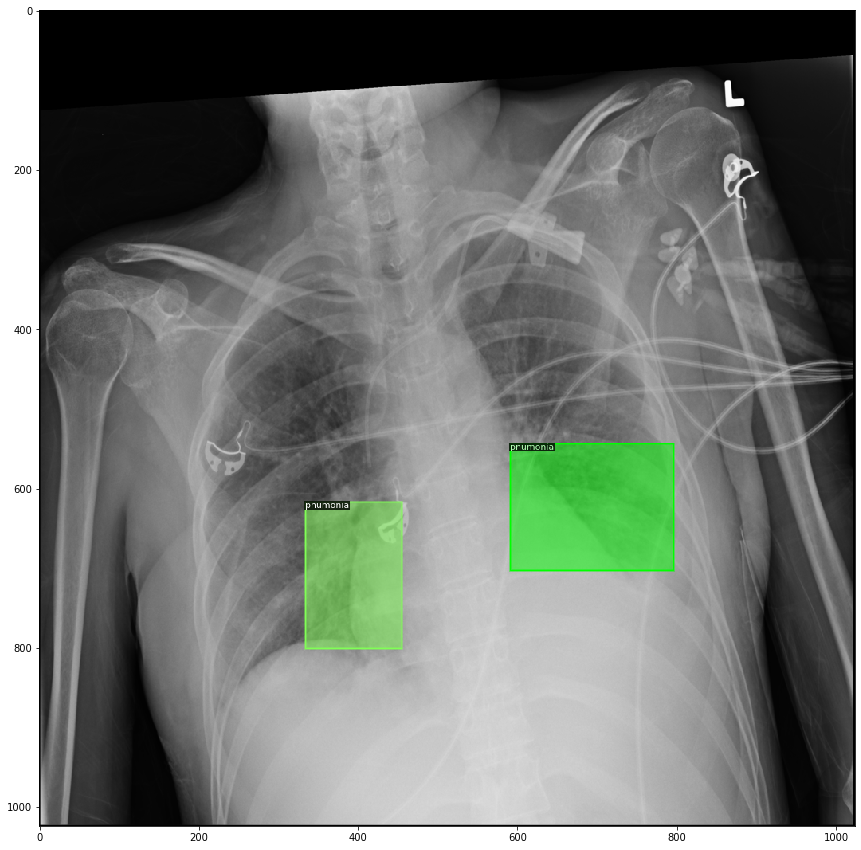

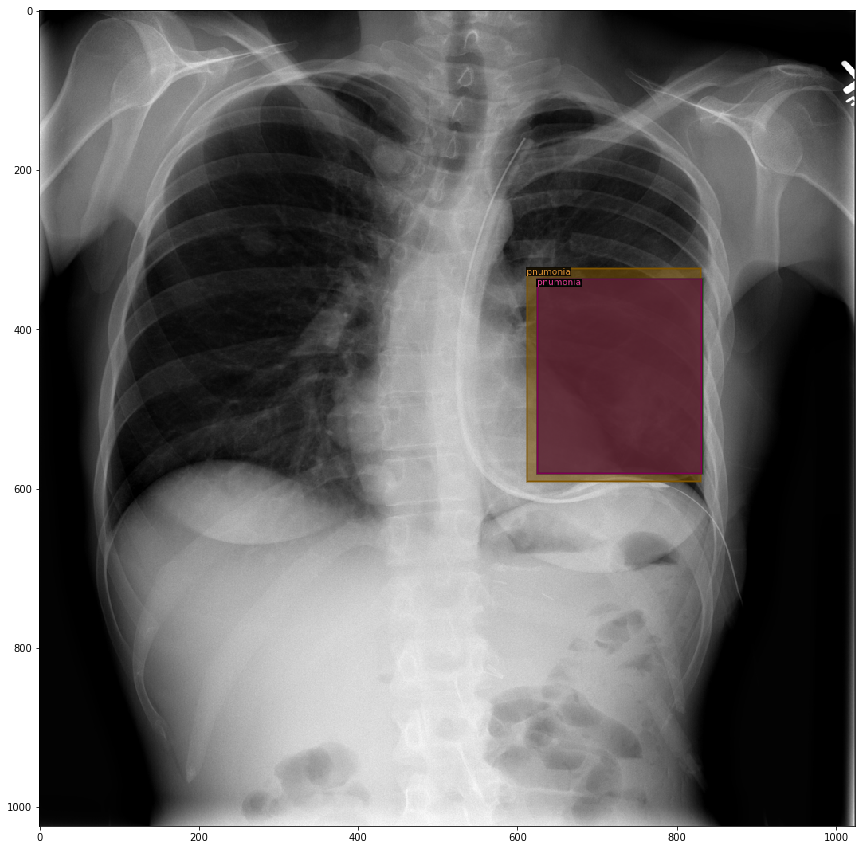

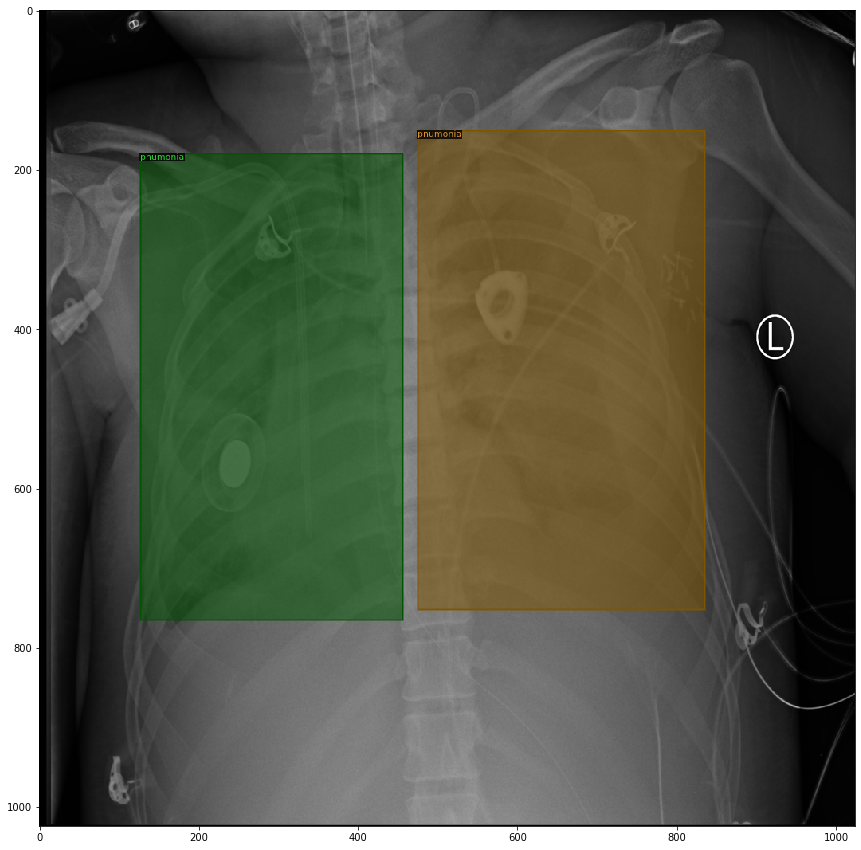

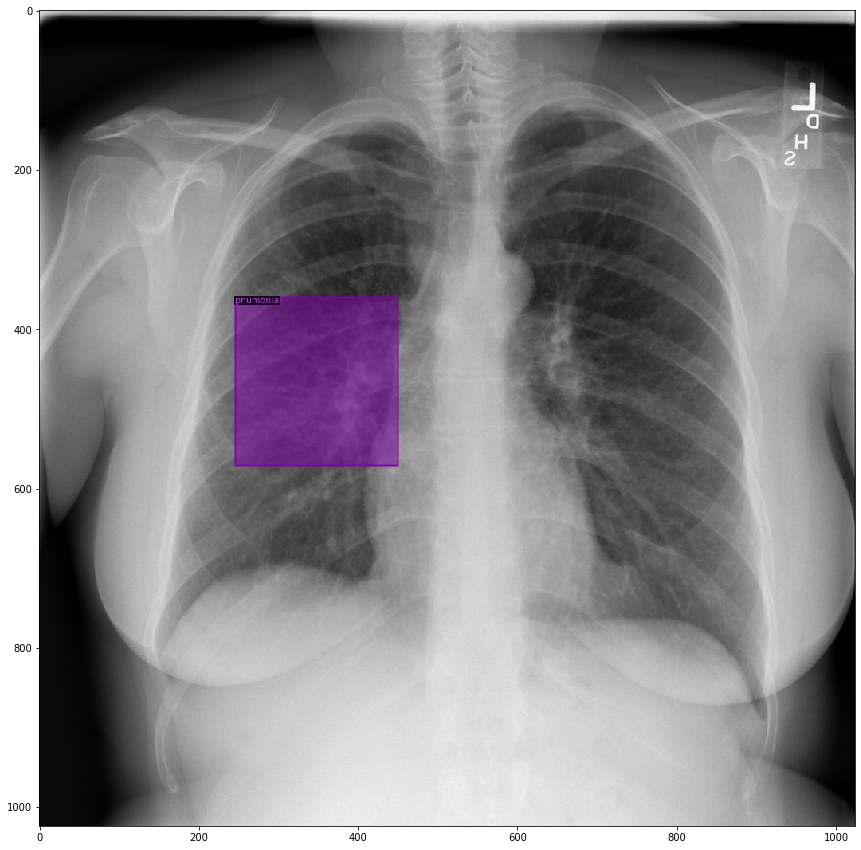

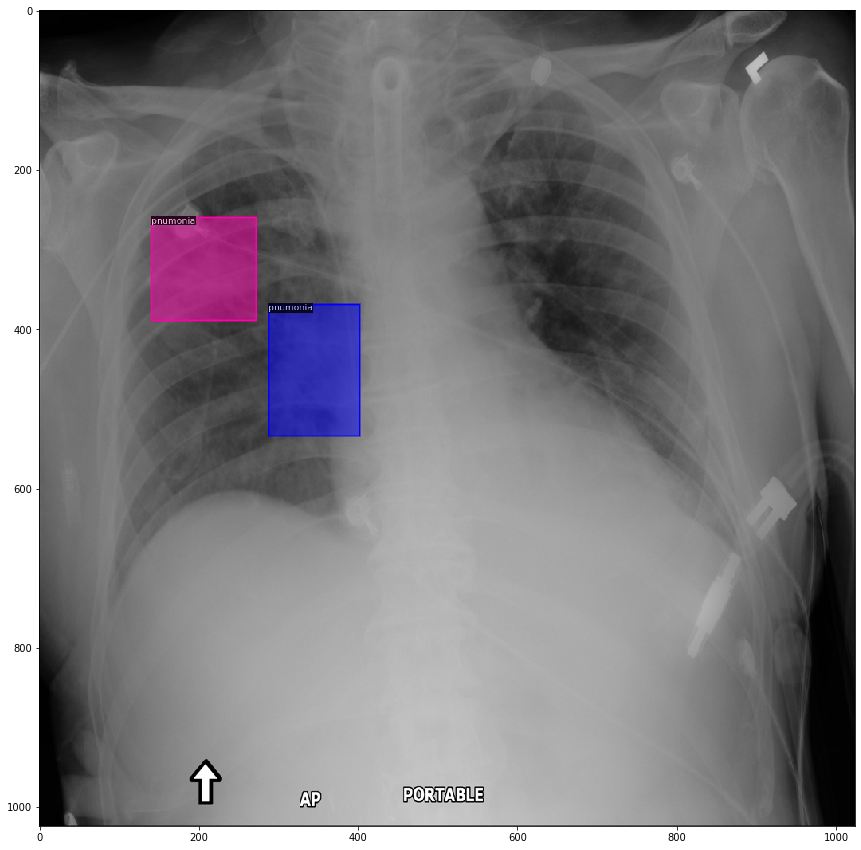

In [7]:
dataset_dicts = RSNA.get_nih_cxr_dicts(0)#Test SET
plt.figure(figsize = (15,15))
for d in dataset_dicts[100:105]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],metadata=NIH_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (15,15))
    plt.imshow(vis.get_image()[:, :, ::-1])

## Train the model on images of Pneumonia (with bbox) on NIH Dataset (RSNA Mappings)

In [9]:
#Time to Train!!!!
epochs = 20

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("RSNA_CXR_TRAIN",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
iterations = int((len(RSNA.merged[RSNA.merged['train']==1])/cfg.SOLVER.IMS_PER_BATCH)*epochs)
cfg.SOLVER.MAX_ITER = iterations# 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (pnumonia)
cfg.SOLVER.WARMUP_ITERS = 1000
#cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = np.linspace(2000, iterations-int(iterations*0.1), num=int(iterations/20000), dtype=np.int).tolist()
cfg.SOLVER.GAMMA = 0.5#divides in half


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/03 01:49:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

### Save Model

In [61]:
from detectron2.checkpoint import DetectionCheckpointer
checkpointer = DetectionCheckpointer(predictor.model, save_dir="output")
checkpointer.save("model_final")  # save to output/model_final.pth

## Predict results

### Create Predictor

In [3]:
#edit this so we can properly load weights
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (pnumonia)
#Just run these lines if you have the trained model im memory
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("RSNA_CXR_TEST", )
predictor = DefaultPredictor(cfg)

### Test images and visualize from test set

tensor([0], device='cuda:0')
Boxes(tensor([[612.5703, 596.0771, 870.9728, 887.4691]], device='cuda:0'))
tensor([0], device='cuda:0')
Boxes(tensor([[715.3616, 442.9187, 823.3691, 560.1931]], device='cuda:0'))
tensor([0, 0], device='cuda:0')
Boxes(tensor([[500.7782, 196.1809, 764.5246, 666.0975],
        [166.7928, 211.5404, 415.8413, 745.9119]], device='cuda:0'))
tensor([0], device='cuda:0')
Boxes(tensor([[211.5585, 326.1393, 460.0737, 685.0641]], device='cuda:0'))
tensor([0], device='cuda:0')
Boxes(tensor([[136.8322, 290.6245, 315.6760, 397.4400]], device='cuda:0'))


<Figure size 1080x1080 with 0 Axes>

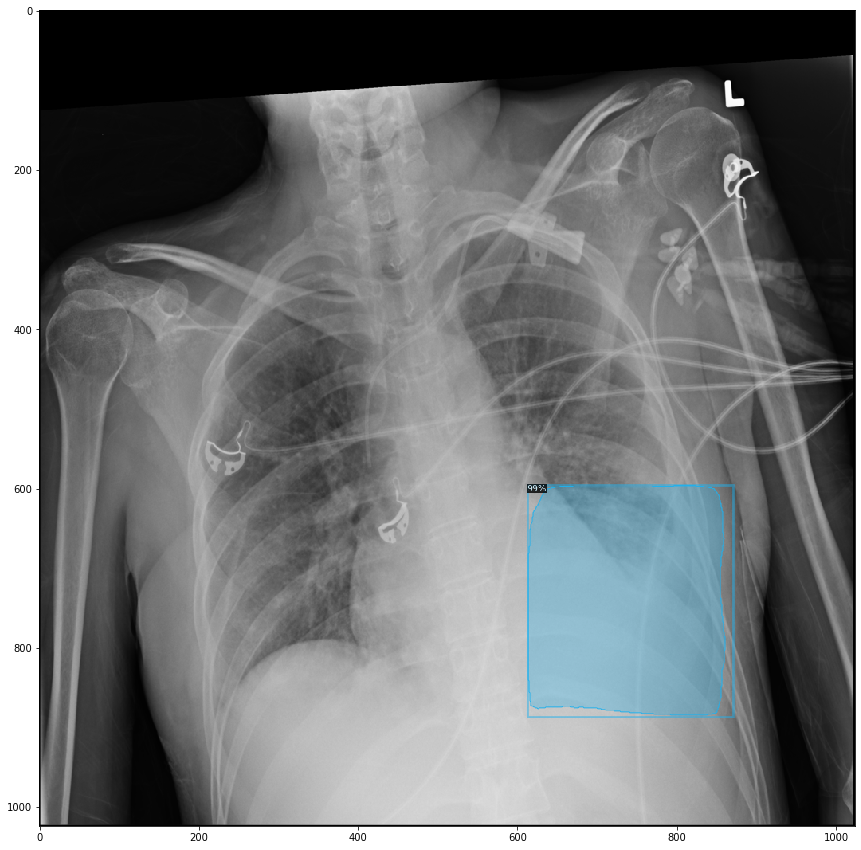

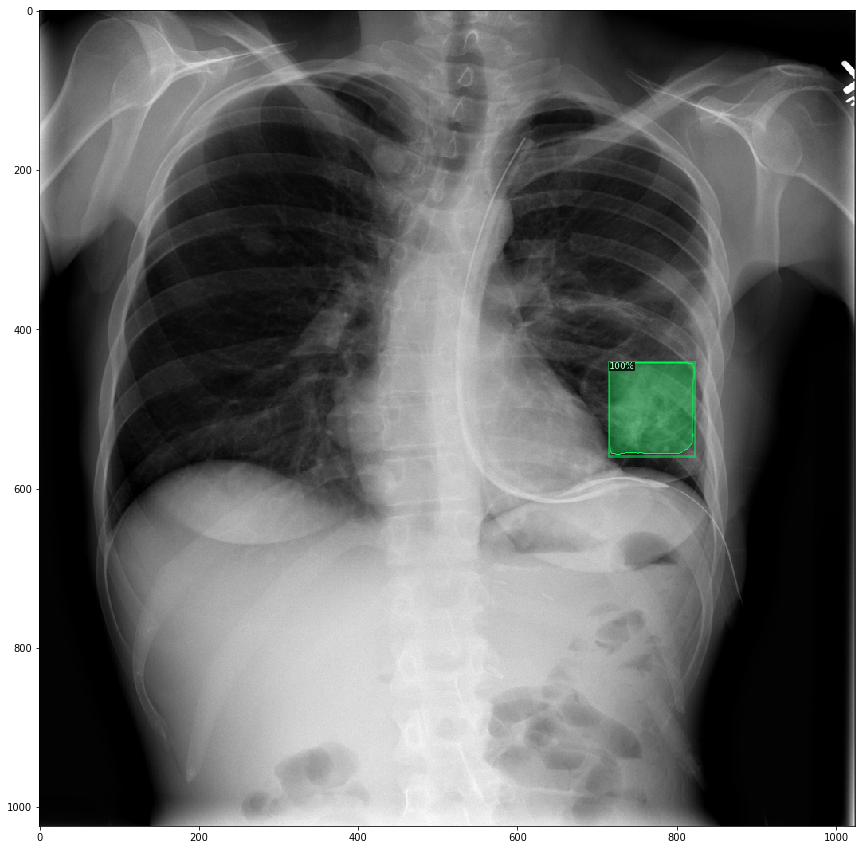

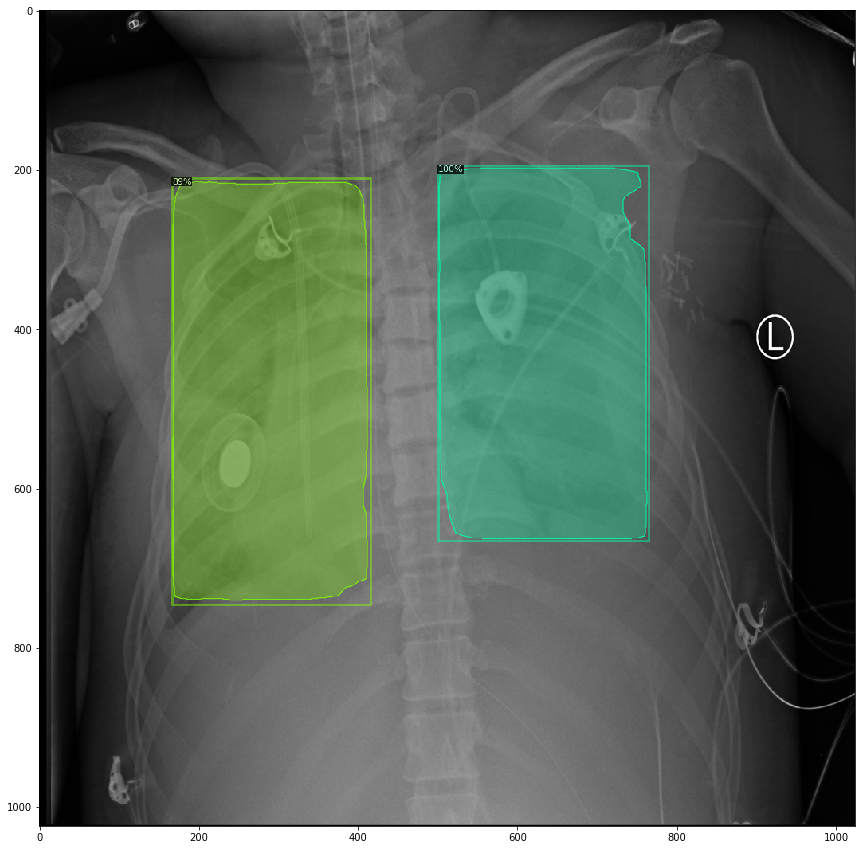

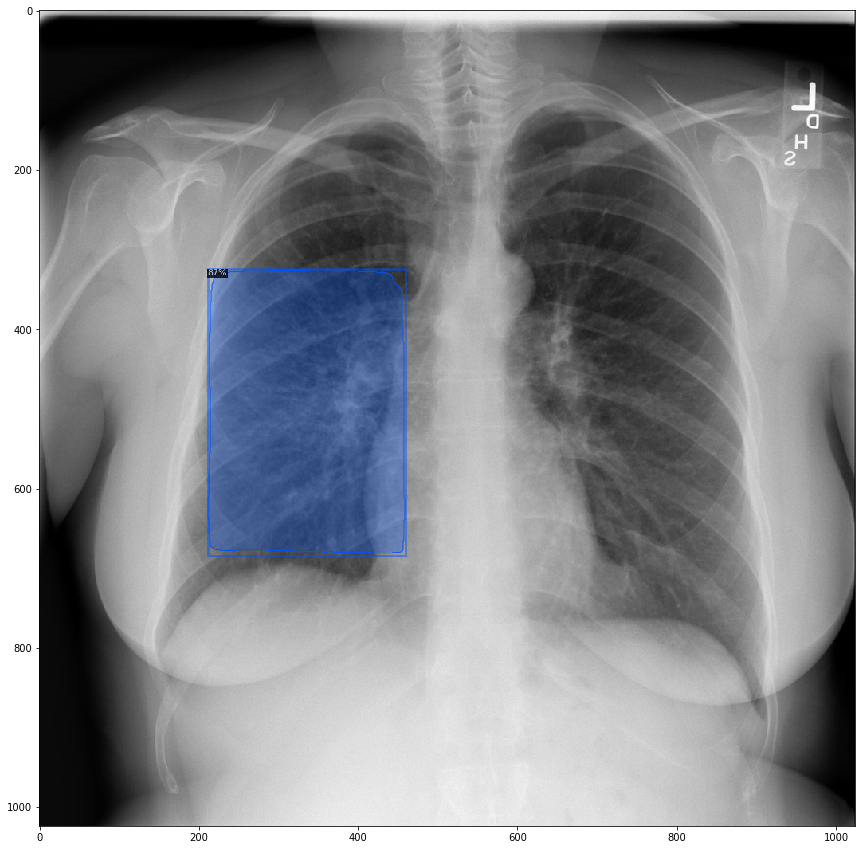

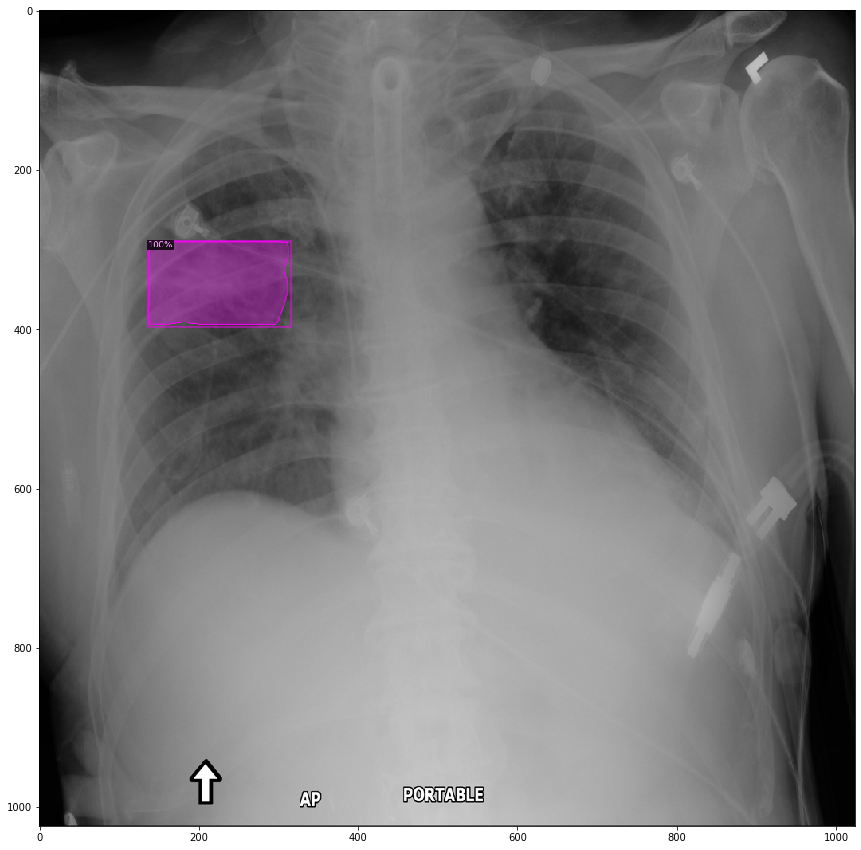

In [9]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = RSNA.get_nih_cxr_dicts(0)#train=0, the TEST set
plt.figure(figsize = (15,15))
for d in dataset_dicts[100:105]:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs["instances"].pred_classes)
    print(outputs["instances"].pred_boxes)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("RSNA_CXR_TEST"), 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (15,15))
    plt.imshow(v.get_image()[:, :, ::-1])

### Test model using the COCOEvaluator

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
evaluator = COCOEvaluator("RSNA_CXR_TEST", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "RSNA_CXR_TEST")
inference_on_dataset(predictor.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [06/05 21:02:54 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'RSNA_CXR_TEST'. Trying to convert it to COCO format ...
WARNING [06/05 21:02:54 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/RSNA_CXR_TEST_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/05 21:02:55 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  pnumonia  | 4514         |
|            |              |
[06/05 21:02:55 d2.data.common]: Serializing 2018 elements to byte tensors and concatenating them all ...
[06/05 21:02:55 d2.data.common]: Serialized dataset takes 1.07 MiB
[06/05 21:02:55 d2.evaluation.evaluator]: Start inference on 2018 images
[06/05 21:02:57 d2.evaluation.evaluator]: Inference done 11/2018. 0.0824 s / img. ETA=0:03:03
[06/05 21:03:02 d2.evaluation.evaluator]: Inference done 66/2018. 0.0820 s / img. ETA=0:

KeyboardInterrupt: 

# Test on MIMIC-CXR-JPG dataset

## Load Dataset & create our dataframe for samples with positive and negative Pneumonia

In [4]:
# test on mimic
mimic_loc = '/home/kl533/krauthammer_partition/mimic-cxr-jpg/mimic-cxr-jpg-2.0.0.physionet.org/'
metadata = pd.read_csv(os.path.join(mimic_loc, "mimic-cxr-2.0.0-metadata.csv"))
chexpert = pd.read_csv(os.path.join(mimic_loc, "mimic-cxr-2.0.0-chexpert.csv"))
splits = pd.read_csv(os.path.join(mimic_loc, "mimic-cxr-2.0.0-split.csv"))

In [5]:
if LOAD_FROM_DISK:
    mimic_df = pd.read_csv('mimic_filelist.csv',index_col=0)
else:
    #get paths of all images in dataset by recursivly searching through the directory
    result = list(Path(mimic_loc).rglob("*.jpg"))
    mimic_df = pd.DataFrame(result, columns=['path'])#put paths into df
    mimic_df.to_csv('mimic_filelist.csv')

In [6]:
mimic_df['dicom_id'] = mimic_df['path'].apply(lambda x: os.path.basename(x).split('.')[0])#get dicom_id

In [7]:
#Merge with metadata to get image position, orientation etc
mimic_merged = pd.merge(metadata, mimic_df, on='dicom_id')

In [8]:
mimic_ap_pa = mimic_merged[(mimic_merged['ViewPosition'] == 'PA') | (mimic_merged['ViewPosition'] == 'AP')]#both posterior to anterior and anterior to posterior
#mimic_ap_pa = mimic_merged[mimic_merged['ViewPosition'] == 'PA']#posterior to anterior

In [9]:
mimic_ap_pa_chexpert = pd.merge(mimic_ap_pa, chexpert, on='study_id')

In [11]:
#with and without pneumonia
mimic_pnumonia = mimic_ap_pa_chexpert[((mimic_ap_pa_chexpert['Pneumonia'] == 1) | (mimic_ap_pa_chexpert['Pneumonia'] == 0))].reset_index()

### Visualize our data

In [12]:
mimic_pnumonia

index                                      dicom_id  subject_id_x  \
0           8  d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738      10000935   
1          14  6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d      10000980   
2          15  943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4      10000980   
3          16  cfb03587-782edf6c-1bf392e1-98196cd5-365d69e8      10000980   
4          21  c7526473-7b7214ee-a5d58d12-29d1f67f-9f4edf00      10000980   
5          26  1fe73f8e-036bd24e-4578c891-33c1746e-864884a7      10001176   
6          31  0009a9fb-eb905e90-824cad7c-16d40468-007f0038      10001401   
7          37  19e55bee-714bb193-0968d683-5bf655a5-7b5caba9      10001401   
8          42  ebf48d65-7e780cd5-59118fba-50977097-3720cc7e      10001884   
9          55  8d4eb7a8-0d3c4f7e-fed33834-ef1c6ffd-e01d0967      10001884   
10         57  79863f89-595bf19b-3c7b514a-42969d9b-eff42368      10001884   
11         83  e8c44648-ff02beea-3d5ff638-dec79b01-7df71a69      10002428   
12         91  3bea0373-0d10dd77-1cac5b90-651be924-d343b184      10002428   
13         98  3dc1b72b-7d6efa14-1f9db998-e46ff2db-2cb7375e      10002428   
14        105  cc0b5db2-cc391879-a10b0ccf-5e554f89-37f1cf99      10002428   
15        111  4873aa08-977bfd31-fb492e64-6ef432d1-3f12cbe3      10002430   
16        115  25423a5e-8c27af51-c2c840f3-b498f42b-8ef8e461      10002559   
17        118  3f4a324f-7967a6b4-91edf0c8-94fbefd4-32402065      10003019   
18        120  c584b5c4-b5b1dad6-a6f30167-c0411948-46379f73      10003019   
19        121  0f5314bd-785b969d-9c2ad2e0-74f0dc6d-2512f690      10003019   
20        125  9f0a463b-dbbe3f8e-d5cf30af-9452e738-5465e7bf      10003019   
21        127  a664e3c4-97f37598-e008ddb5-674d8b24-8a49114f      10003019   
22        145  7a6f7a0e-452b83e5-d8388f3b-c424f2e2-83d372bd      10003400   
23        166  1fa79752-9ddaf5b5-2120ae82-9fec50d6-51f48d1f      10003502   
24        167  550e6f3b-f008c1d0-8d2dee2a-649b30f4-101a98cc      10003502   
25        173  4c028244-47499ecc-3fab489b-15ec1e76-47055a4d      10003637   
26        174  6aeadf6d-56fb29f1-81351e24-cedb543d-4c8fa419      10003637   
27        176  f6119cd4-a5ef793e-db8543a2-f8d4a0e1-8c8aeb54      10003637   
28        177  dc29d33e-bcf77ecf-c4fca6b6-8ea2ed29-d71aee14      10003956   
29        180  d71a4931-5c0832b8-ae60fd56-1e3658d3-a392959a      10004235   
...       ...                                           ...           ...   
41495  243132  5bfc7136-aa75ca73-d0ffa1ea-707b7ea4-3d55b433      19995012   
41496  243134  7e42e728-c9c58de4-4d3c8a83-85d13b61-51100964      19995127   
41497  243152  653f7936-09b7e7f7-3e5f154c-98d78fa3-faa4f78c      19995366   
41498  243153  044edb57-67e75e13-ec2be2d0-3d17ed97-ec25cefb      19995593   
41499  243154  6802705a-01cbc4ee-94001728-a7c5f086-bfaf1071      19995780   
41500  243161  5df00fef-29f8142d-810768f9-48dc1dec-35cdfc74      19996786   
41501  243162  ff766df0-156bec0b-d33db351-26d340dd-4711ae6f      19996786   
41502  243165  d9eedfc8-38f766ac-309f0c5f-cea553c3-d06b9b23      19997087   
41503  243166  9d3ea5ad-40b2fcbb-b309d9fa-7bebdc60-e028d434      19997087   
41504  243167  caf5ea1f-33cfc639-03813873-00c6b0e4-a0651091      19997087   
41505  243173  3d12d866-7fc53c50-e5f9fb8e-4734dce6-9ef1b63a      19997293   
41506  243174  91224c24-89f5a5eb-914ecc68-a57b6dcd-151cc2fb      19997293   
41507  243176  b7c6e487-b22d02c1-577476ea-07fa9244-9aed3945      19997293   
41508  243177  d687962e-912dcc7f-8c9d173a-8eecdaa5-eb9448f8      19997293   
41509  243182  92f9099d-31a13eef-116a7c3b-a6484f70-0ceaca88      19997293   
41510  243183  05eb5a3c-80402222-598417a2-2a945a8f-52990aa8      19997293   
41511  243201  9c7dfdd3-e6f6f1e6-43907e2d-dabcc021-4182787c      19997367   
41512  243204  3a1b9808-1c11f08b-050a2bc0-374f9e2c-8400b08c      19997367   
41513  243210  60492c2d-06c94a4b-6a7cd4ad-4fc8daad-8b87e849      19997367   
41514  243218  4a7125ab-9e7671a9-10b55fe2-11233ecc-a9a4558a      19997367   
4151

In [ ]:
idx = 0
im = cv2.imread(str(mimic_pnumonia['path'].iloc[idx]))
outputs = predictor(im)

In [ ]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
#v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
v = v.overlay_instances(boxes=outputs["instances"].pred_boxes.to("cpu").tensor.tolist(), assigned_colors=['b', 'b', 'b', 'b'])#draw only bounding box in color
plt.figure(figsize = (15,15))
plt.imshow(v.get_image()[:, :, ::-1])
#plt.savefig(mimic_pnumonia.iloc[idx]['dicom_id'] + '_ANNOTATED.jpg')

### Load the reports from the original MIMIC-CXR v2.0

In [9]:
#get mimic reports
if LOAD_FROM_DISK:
    reports_df = pd.read_csv('mimic_reports.csv',index_col=0)
else:
    reports_loc = '/home/kl533/krauthammer_partition/MIMIC_CXR/mimic-cxr-2.0.0.physionet.org/files/'
    reports_df = pd.DataFrame(list(Path(reports_loc).rglob("*.txt")), columns=['report_path'])
    reports_df['report_path'] = reports_df['report_path'].apply(lambda x: str(x))
    reports_df['study_id'] = reports_df['report_path'].apply(lambda x: os.path.basename(x).split('.')[0])
    reports_df['study_id'] = reports_df['study_id'].apply(lambda x: int(x[1:]))#remove s and turn it into int
    reports_df.to_csv('mimic_reports.csv')

In [10]:
'''
Gives us what we need for our feature extractor.
Takes report_df and our image_df (data from images) and merge them
'''
def feature_gen_input(img_df, report_df):
    outs = []
    for index, row in img_df.iterrows():
        y = row['Pneumonia']
        if index % 500 == 0:
            print('At index: {}'.format(index))
        #should be a better way to do this
        report_path = report_df[report_df['study_id'] == row['study_id']]['report_path'].values[0]
        report = open(report_path,'r').read()
        # dicom_id, bbox, detected_pneumonia, report, study_id
        outs.append([row['dicom_id'], str(row['path']), report_path, report, row['study_id'], int(y)])
    print('DONE!')
    return pd.DataFrame(outs, columns = ['dicom_id', 'path', 'report_path', 'report', 'study_id', 'y'])

In [32]:
if LOAD_FROM_DISK:
    outputs_df = pd.read_csv('mimic_outputs.csv', index_col=0)
else:    
    outputs_df = feature_gen_input(mimic_pnumonia, reports_df)
    outputs_df.to_csv('mimic_outputs.csv', index=True)
    outputs_df

# Extract features

This is a feature extractor using Detectron2 based on VilBerts FE using maskrcnn-benchmark

In [13]:
import traceback
DEBUG = False
    
class feature_extractor:
    '''
    Feature Extractor for detectron2
    '''
    def __init__(self, path = None, output_folder='./output', model = None, pred_thresh = 0.5):
        self.pred_thresh = pred_thresh
        self.output_folder = output_folder
        assert path is not None, 'Path should not be none'
        self.path = path
        if model == None:
            self.model = self._build_detection_model()
        else:
            assert model == detectron2.engine.defaults.DefaultPredictor, "model should be 'detectron2.engine.defaults.DefaultPredictor'"#
            self.model = model
            self.model.eval()
    def _build_detection_model(self):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
        cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
        cfg.SOLVER.IMS_PER_BATCH = 1
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (pnumonia)
        #Just run these lines if you have the trained model im memory
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = self.pred_thresh   # set the testing threshold for this model
        #build model and return
        return DefaultPredictor(cfg)
    def _process_feature_extraction(self, inputs):#step 3
        '''
        #predictor.model.roi_heads.box_predictor.test_topk_per_image = 1000
        #predictor.model.roi_heads.box_predictor.test_nms_thresh = 0.99
        #predictor.model.roi_heads.box_predictor.test_score_thresh = 0.0
        #pred_boxes = [x.pred_boxes for x in instances]#can use prediction boxes
        '''
        torch.cuda.empty_cache()
        predictor = self.model
        with torch.no_grad():#https://detectron2.readthedocs.io/_modules/detectron2/modeling/roi_heads/roi_heads.html : _forward_box()
            images = predictor.model.preprocess_image(inputs)  # don't forget to preprocess, this is done in another step
            features = predictor.model.backbone(images.tensor)  # set of cnn features
            proposals, _ = predictor.model.proposal_generator(images, features, None)  # RPN

            features_ = [features[f] for f in predictor.model.roi_heads.box_in_features]
            box_features = predictor.model.roi_heads.box_pooler(features_, [x.proposal_boxes for x in proposals])
            box_features = predictor.model.roi_heads.box_head(box_features)  # features of all 1k candidates
            predictions = predictor.model.roi_heads.box_predictor(box_features)#found here: https://detectron2.readthedocs.io/_modules/detectron2/modeling/roi_heads/roi_heads.html            
            '''First, it applies box deltas to readjust the proposal boxes. Then it computes Non-Maximum Suppression 
            to remove non-overlapping boxes (while also applying other hyper-settings such as score threshold). 
            Finally, it ranks top-k boxes according to their scores. #something to do with: NMS threshold for prediction results. 
            found: https://github.com/facebookresearch/detectron2/blob/master/detectron2/modeling/roi_heads/fast_rcnn.py#L460'''
            pred_instances, pred_inds = predictor.model.roi_heads.box_predictor.inference(predictions, proposals)
            pred_instances = predictor.model.roi_heads.forward_with_given_boxes(features, pred_instances)

            # output boxes, masks, scores, etc
            pred_instances = predictor.model._postprocess(pred_instances, inputs, images.image_sizes)  # scale box to orig size
            # features of the proposed boxes
            feats = box_features[pred_inds].to('cpu')
            #['bbox', 'num_boxes', 'objects', 'cls_prob', 'image_id', 'features']
            #img.image_sizes[0]#h, w
            instances = pred_instances[0]['instances'].to('cpu')#send to cpu
            num_instances = len(instances)
            assert num_instances > 0, 'No detected features!'
            result = {
                'bbox': instances.pred_boxes.tensor.numpy(),
                'num_boxes' : num_instances,#len(pred_instances[0]['instances'].pred_boxes[pred_inds].tensor.cpu().numpy()),
                'objects' : instances.pred_classes.numpy(),#pred_instances[0]['instances'].pred_classes.cpu().numpy(),
                'cls_prob': instances.scores.numpy(),#pred_instances[0]['instances'].scores.cpu().numpy(),
                'features': feats.to('cpu').numpy()
            }
        return result
            
    def _save_feature(self, file_name, feature, info):
        file_base_name = os.path.basename(file_name)
        file_base_name = file_base_name.split(".")[0]
        feature["image_id"] = file_base_name
        feature['image_height'] = info['height']
        feature['image_width'] = info['width']
        file_base_name = file_base_name + ".npy"
        np.save(os.path.join(self.output_folder, file_base_name), feature)
        
    def extract_features(self):#step 1
        #torch.cuda.empty_cache()
        image_dir = self.path
        #print(image_dir)
        if type(image_dir) == pd.core.frame.DataFrame:#or pandas.core.frame.DataFrame. Iterate over a dataframe
            samples = []
            for idx, row in image_dir.iterrows():#get better name
                file = row['path']
                try:
                    features, infos = self.get_detectron2_features([file])
                    self._save_feature(file, features, infos[0])
                    samples.append(row)
                except Exception as e:#if no features were found!
                    print('An exception has occurred: {}'.format(e))
                    if DEBUG:
                        traceback.print_exc()
                    continue
            df = pd.DataFrame(samples)
            #save final csv containing image base names, reports and report locations
            df.to_csv(os.path.join(self.output_folder, 'img_infos.csv'))
        elif os.path.isfile(image_dir):#if its a single file
            features, infos = self.get_detectron2_features([image_dir])
            self._save_feature(image_dir, features[0], infos[0])
            return features, infos
        else:#if its a directory
            files = glob.glob(os.path.join(image_dir, "*"))
            for idx, file in enumerate(files):
                try:
                    features, infos = self.get_detectron2_features([file])
                    self._save_feature(file, features, infos[0])
                except Exception as e:#if no features were found!
                    print('An exception has occurred: {}'.format(e))
                    if DEBUG:
                        traceback.print_exc()
                    continue

    def get_detectron2_features(self, image_paths):#step 2
        #we have to PREPROCESS the tensor before partially executing it!
        #taken from https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/defaults.py
        predictor = self.model
        images = []
        image_info = []
        for image_path in image_paths:
            img = cv2.imread(image_path)
            height, width = img.shape[:2]
            img = predictor.transform_gen.get_transform(img).apply_image(img)
            img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1))
            images.append({"image": img, "height": height, "width": width})
            image_info.append({"image_id": os.path.basename(image_path), "height": height, "width": width})
        #returns features and infos
        return self._process_feature_extraction(images), image_info
        

In [14]:
outputs_df

dicom_id  \
0      d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738   
1      6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d   
2      943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4   
3      cfb03587-782edf6c-1bf392e1-98196cd5-365d69e8   
4      c7526473-7b7214ee-a5d58d12-29d1f67f-9f4edf00   
5      1fe73f8e-036bd24e-4578c891-33c1746e-864884a7   
6      0009a9fb-eb905e90-824cad7c-16d40468-007f0038   
7      19e55bee-714bb193-0968d683-5bf655a5-7b5caba9   
8      ebf48d65-7e780cd5-59118fba-50977097-3720cc7e   
9      8d4eb7a8-0d3c4f7e-fed33834-ef1c6ffd-e01d0967   
10     79863f89-595bf19b-3c7b514a-42969d9b-eff42368   
11     e8c44648-ff02beea-3d5ff638-dec79b01-7df71a69   
12     3bea0373-0d10dd77-1cac5b90-651be924-d343b184   
13     3dc1b72b-7d6efa14-1f9db998-e46ff2db-2cb7375e   
14     cc0b5db2-cc391879-a10b0ccf-5e554f89-37f1cf99   
15     4873aa08-977bfd31-fb492e64-6ef432d1-3f12cbe3   
16     25423a5e-8c27af51-c2c840f3-b498f42b-8ef8e461   
17     3f4a324f-7967a6b4-91edf0c8-94fbefd4-32402065   
18     c584b5c4-b5b1dad6-a6f30167-c0411948-46379f73   
19     0f5314bd-785b969d-9c2ad2e0-74f0dc6d-2512f690   
20     9f0a463b-dbbe3f8e-d5cf30af-9452e738-5465e7bf   
21     a664e3c4-97f37598-e008ddb5-674d8b24-8a49114f   
22     7a6f7a0e-452b83e5-d8388f3b-c424f2e2-83d372bd   
23     1fa79752-9ddaf5b5-2120ae82-9fec50d6-51f48d1f   
24     550e6f3b-f008c1d0-8d2dee2a-649b30f4-101a98cc   
25     4c028244-47499ecc-3fab489b-15ec1e76-47055a4d   
26     6aeadf6d-56fb29f1-81351e24-cedb543d-4c8fa419   
27     f6119cd4-a5ef793e-db8543a2-f8d4a0e1-8c8aeb54   
28     dc29d33e-bcf77ecf-c4fca6b6-8ea2ed29-d71aee14   
29     d71a4931-5c0832b8-ae60fd56-1e3658d3-a392959a   
...                                             ...   
41495  5bfc7136-aa75ca73-d0ffa1ea-707b7ea4-3d55b433   
41496  7e42e728-c9c58de4-4d3c8a83-85d13b61-51100964   
41497  653f7936-09b7e7f7-3e5f154c-98d78fa3-faa4f78c   
41498  044edb57-67e75e13-ec2be2d0-3d17ed97-ec25cefb   
41499  6802705a-01cbc4ee-94001728-a7c5f086-bfaf1071   
41500  5df00fef-29f8142d-810768f9-48dc1dec-35cdfc74   
41501  ff766df0-156bec0b-d33db351-26d340dd-4711ae6f   
41502  d9eedfc8-38f766ac-309f0c5f-cea553c3-d06b9b23   
41503  9d3ea5ad-40b2fcbb-b309d9fa-7bebdc60-e028d434   
41504  caf5ea1f-33cfc639-03813873-00c6b0e4-a0651091   
41505  3d12d866-7fc53c50-e5f9fb8e-4734dce6-9ef1b63a   
41506  91224c24-89f5a5eb-914ecc68-a57b6dcd-151cc2fb   
41507  b7c6e487-b22d02c1-577476ea-07fa9244-9aed3945   
41508  d687962e-912dcc7f-8c9d173a-8eecdaa5-eb9448f8   
41509  92f9099d-31a13eef-116a7c3b-a6484f70-0ceaca88   
41510  05eb5a3c-80402222-598417a2-2a945a8f-52990aa8   
41511  9c7dfdd3-e6f6f1e6-43907e2d-dabcc021-4182787c   
41512  3a1b9808-1c11f08b-050a2bc0-374f9e2c-8400b08c   
41513  60492c2d-06c94a4b-6a7cd4ad-4fc8daad-8b87e849   
41514  4a7125ab-9e7671a9-10b55fe2-11233ecc-a9a4558a   
41515  1dd48e29-ef2ba588-b54695a3-4946bfae-aee25cd6   
41516  56da196c-fd95430d-7f304acc-53ae3e4b-2a0af448   
41517  0420f078-3bcc3e30-6c542886-38bf1221-fed712aa   
41518  2521d582-fe099130-01bf964d-3ea70c67-3c065d57   
41519  dc371609-0205dcda-757e4f29-8d309de6-39dbff0f   
41520  0802e3d3-5c5c09e8-eddfff18-c451289a-1fb33127   
41521  a29987d8-abd13298-7a067b12-620f9fdb-103ecf53   
41522  518011e2-346dbd44-3e738335-c5006bf8-d69f6b68   
41523  1427ad57-5bf4f3e6-90be02f3-d1760987-99d7f2ce   
41524  23ba9adb-5344e3bc-0a9e5a61-80f56ec1-df4c0a97   

                                                    path  \
0      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
1      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
2      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
3      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
4      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
5      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
6      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
7      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
8      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
9      /home/kl533/krauthammer_p

In [599]:
outputs_df[outputs_df['dicom_id'] == 'e5ba5704-ce2f09d3-e28fe2a2-8a9aca96-86f4966a'].path.values

array(['/home/kl533/krauthammer_partition/mimic-cxr-jpg/mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10046166/s57379357/e5ba5704-ce2f09d3-e28fe2a2-8a9aca96-86f4966a.jpg'],
      dtype=object)

In [15]:
fe = feature_extractor(path=outputs_df, output_folder='/home/kl533/krauthammer_partition/Weights/transforming_embracement', pred_thresh=0.5)

In [ ]:
fe.extract_features()

An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occurred: No detected features!
An exception has occ

In [13]:
outputs_df

dicom_id  \
0      d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738   
1      6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d   
2      943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4   
3      cfb03587-782edf6c-1bf392e1-98196cd5-365d69e8   
4      c7526473-7b7214ee-a5d58d12-29d1f67f-9f4edf00   
5      1fe73f8e-036bd24e-4578c891-33c1746e-864884a7   
6      0009a9fb-eb905e90-824cad7c-16d40468-007f0038   
7      19e55bee-714bb193-0968d683-5bf655a5-7b5caba9   
8      ebf48d65-7e780cd5-59118fba-50977097-3720cc7e   
9      8d4eb7a8-0d3c4f7e-fed33834-ef1c6ffd-e01d0967   
10     79863f89-595bf19b-3c7b514a-42969d9b-eff42368   
11     e8c44648-ff02beea-3d5ff638-dec79b01-7df71a69   
12     3bea0373-0d10dd77-1cac5b90-651be924-d343b184   
13     3dc1b72b-7d6efa14-1f9db998-e46ff2db-2cb7375e   
14     cc0b5db2-cc391879-a10b0ccf-5e554f89-37f1cf99   
15     4873aa08-977bfd31-fb492e64-6ef432d1-3f12cbe3   
16     25423a5e-8c27af51-c2c840f3-b498f42b-8ef8e461   
17     3f4a324f-7967a6b4-91edf0c8-94fbefd4-32402065   
18     c584b5c4-b5b1dad6-a6f30167-c0411948-46379f73   
19     0f5314bd-785b969d-9c2ad2e0-74f0dc6d-2512f690   
20     9f0a463b-dbbe3f8e-d5cf30af-9452e738-5465e7bf   
21     a664e3c4-97f37598-e008ddb5-674d8b24-8a49114f   
22     7a6f7a0e-452b83e5-d8388f3b-c424f2e2-83d372bd   
23     1fa79752-9ddaf5b5-2120ae82-9fec50d6-51f48d1f   
24     550e6f3b-f008c1d0-8d2dee2a-649b30f4-101a98cc   
25     4c028244-47499ecc-3fab489b-15ec1e76-47055a4d   
26     6aeadf6d-56fb29f1-81351e24-cedb543d-4c8fa419   
27     f6119cd4-a5ef793e-db8543a2-f8d4a0e1-8c8aeb54   
28     dc29d33e-bcf77ecf-c4fca6b6-8ea2ed29-d71aee14   
29     d71a4931-5c0832b8-ae60fd56-1e3658d3-a392959a   
...                                             ...   
41495  5bfc7136-aa75ca73-d0ffa1ea-707b7ea4-3d55b433   
41496  7e42e728-c9c58de4-4d3c8a83-85d13b61-51100964   
41497  653f7936-09b7e7f7-3e5f154c-98d78fa3-faa4f78c   
41498  044edb57-67e75e13-ec2be2d0-3d17ed97-ec25cefb   
41499  6802705a-01cbc4ee-94001728-a7c5f086-bfaf1071   
41500  5df00fef-29f8142d-810768f9-48dc1dec-35cdfc74   
41501  ff766df0-156bec0b-d33db351-26d340dd-4711ae6f   
41502  d9eedfc8-38f766ac-309f0c5f-cea553c3-d06b9b23   
41503  9d3ea5ad-40b2fcbb-b309d9fa-7bebdc60-e028d434   
41504  caf5ea1f-33cfc639-03813873-00c6b0e4-a0651091   
41505  3d12d866-7fc53c50-e5f9fb8e-4734dce6-9ef1b63a   
41506  91224c24-89f5a5eb-914ecc68-a57b6dcd-151cc2fb   
41507  b7c6e487-b22d02c1-577476ea-07fa9244-9aed3945   
41508  d687962e-912dcc7f-8c9d173a-8eecdaa5-eb9448f8   
41509  92f9099d-31a13eef-116a7c3b-a6484f70-0ceaca88   
41510  05eb5a3c-80402222-598417a2-2a945a8f-52990aa8   
41511  9c7dfdd3-e6f6f1e6-43907e2d-dabcc021-4182787c   
41512  3a1b9808-1c11f08b-050a2bc0-374f9e2c-8400b08c   
41513  60492c2d-06c94a4b-6a7cd4ad-4fc8daad-8b87e849   
41514  4a7125ab-9e7671a9-10b55fe2-11233ecc-a9a4558a   
41515  1dd48e29-ef2ba588-b54695a3-4946bfae-aee25cd6   
41516  56da196c-fd95430d-7f304acc-53ae3e4b-2a0af448   
41517  0420f078-3bcc3e30-6c542886-38bf1221-fed712aa   
41518  2521d582-fe099130-01bf964d-3ea70c67-3c065d57   
41519  dc371609-0205dcda-757e4f29-8d309de6-39dbff0f   
41520  0802e3d3-5c5c09e8-eddfff18-c451289a-1fb33127   
41521  a29987d8-abd13298-7a067b12-620f9fdb-103ecf53   
41522  518011e2-346dbd44-3e738335-c5006bf8-d69f6b68   
41523  1427ad57-5bf4f3e6-90be02f3-d1760987-99d7f2ce   
41524  23ba9adb-5344e3bc-0a9e5a61-80f56ec1-df4c0a97   

                                                    path  \
0      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
1      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
2      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
3      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
4      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
5      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
6      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
7      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
8      /home/kl533/krauthammer_partition/mimic-cxr-jp...   
9      /home/kl533/krauthammer_p

'/home/kl533/krauthammer_partition/mimic-cxr-jpg/mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p10000935/s50578979/d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738.jpg'

In [10]:
import torch
print(torch.__version__)

1.5.0+cu101


In [4]:
LOAD_FROM_DISK = True

In [574]:
import torch.nn as nn
import torch.nn.functional as F
#np.shape(nn.AvgPool2d(box_pooled_features[0]))

In [607]:
torch.cuda.empty_cache()
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (pnumonia)
#Just run these lines if you have the trained model im memory
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
#build model and return
predictor = DefaultPredictor(cfg)
#extract features
#img_name = 'input.jpg'
img_name = outputs_df.iloc[2]['path']
image = cv2.imread(img_name)
height, width = image.shape[:2]
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
inputs = [{"image": image, "height": height, "width": width}]
with torch.no_grad():
    images = predictor.model.preprocess_image(inputs)  # don't forget to preprocess
    features = predictor.model.backbone(images.tensor)  # set of cnn features
    proposals, _ = predictor.model.proposal_generator(images, features, None)  # RPN

    features_ = [features[f] for f in predictor.model.roi_heads.box_in_features]
    box_pooled_features = predictor.model.roi_heads.box_pooler(features_, [x.proposal_boxes for x in proposals])
    box_features = predictor.model.roi_heads.box_head(box_pooled_features)  # features of all 1k candidates
    predictions = predictor.model.roi_heads.box_predictor(box_features)
    pred_instances, pred_inds = predictor.model.roi_heads.box_predictor.inference(predictions, proposals)
    pred_instances = predictor.model.roi_heads.forward_with_given_boxes(features, pred_instances)

    # output boxes, masks, scores, etc
    pred_instances = predictor.model._postprocess(pred_instances, inputs, images.image_sizes)  # scale box to orig size
    # features of the proposed boxes
    feats = box_features[pred_inds]

In [608]:
print(len(pred_instances))

1


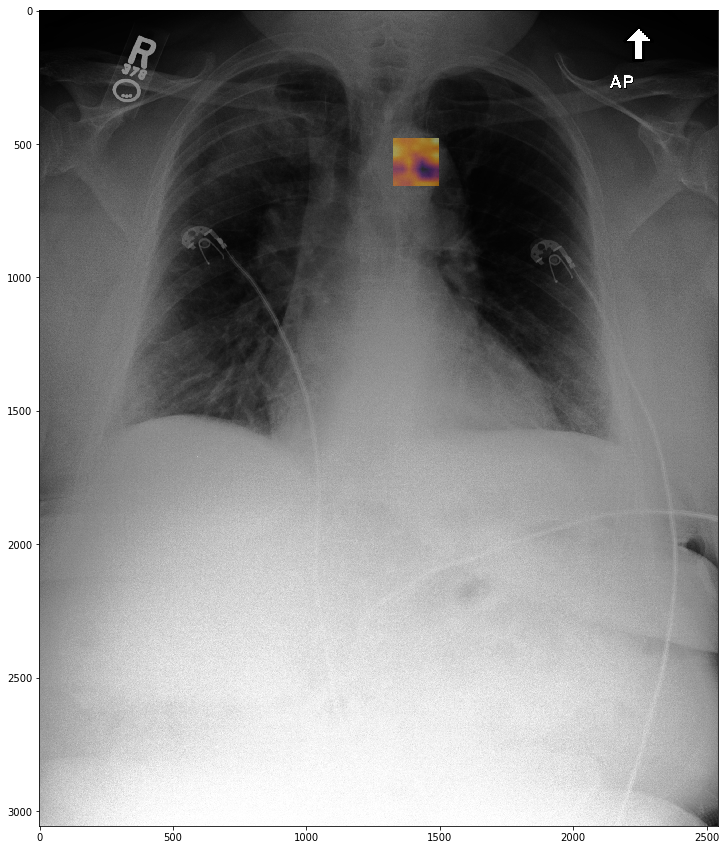

In [609]:
box_no = 0
x = box_pooled_features[box_no]
bbox = pred_instances[0]['instances'].pred_boxes[box_no].tensor.cpu().numpy().tolist()[0]#x & y are here
image = cv2.imread(img_name)
x0,y0, x1,y1 = [int(x) for x in bbox]
width = x1-x0
height =y1-y0
#height, width = image.shape[:2]
dim = (int(width), int(height))
img_map = torch.mean(x.view(x.size(0), x.size(1), -1), dim=0).cpu().numpy()
img_map = cv2.resize(img_map, dim)#take in as (width, height)

#gen heat map from features
heatmap = cv2.cvtColor(cv2.applyColorMap(cv2.normalize(img_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, 
                                                       dtype=cv2.CV_8U), cv2.COLORMAP_INFERNO), cv2.COLOR_BGR2RGB)#have to convert to RGB to visualize
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
overlay = np.copy(image)
overlay[y0:y1, x0:x1,:] = heatmap

plt.figure(figsize = (15,15))
plt.imshow(cv2.addWeighted(image,0.5,overlay,0.5,0))

In [606]:
pred_instances[0]['instances']

Instances(num_instances=0, image_height=2022, image_width=1870, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 2022, 1870), dtype=torch.uint8)])

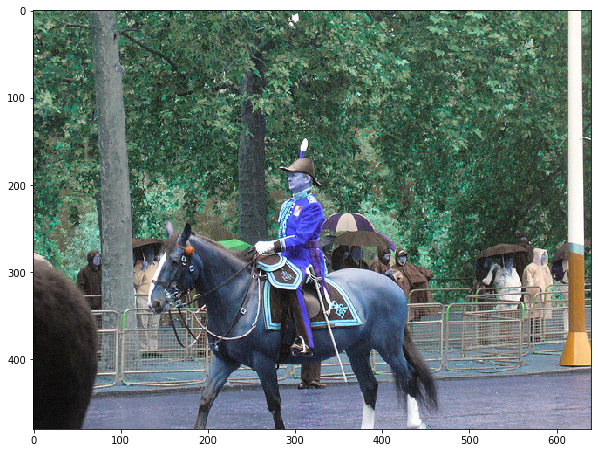

In [405]:
plt.figure(figsize = (10,10))
plt.imshow(image[:,:,:])

In [359]:
cv2.applyColorMap(cv2.cvtColor(img_map, cv2.CV_8UC1), cv2.COLORMAP_HOT)

array([[[  0, 208, 255],
        [  0, 208, 255],
        [  0, 208, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0, 208, 255],
        [  0, 208, 255],
        [  0, 208, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0, 208, 255],
        [  0, 208, 255],
        [  0, 208, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  0,   0, 175],
        [  0,   0, 175],
        [  0,   0, 175],
        ...,
        [  0,  50, 255],
        [  0,  50, 255],
        [  0,  50, 255]],

       [[  0,   0, 175],
        [  0,   0, 175],
        [  0,   0, 175],
        ...,
        [  0,  50, 255],
        [  0,  50, 255],
        [  0,  50, 255]],

       [[  0,   0, 175],
        [  0,   0, 175],
        [  0,   0, 175],
        ...,
        [  0,  50, 255],
        [  0,  50, 255],
        [  0,  50, 255]]

array([[185, 185, 185, ..., 255, 255, 255],
       [185, 185, 185, ..., 255, 255, 255],
       [185, 185, 185, ..., 255, 255, 255],
       ...,
       [ 70,  70,  70, ..., 122, 122, 122],
       [ 70,  70,  70, ..., 122, 122, 122],
       [ 70,  70,  70, ..., 122, 122, 122]], dtype=uint8)

In [274]:
print(x_)
print(width)
print(y_)
print(height)

594
611
292
318


In [275]:
pred_instances

[{'instances': Instances(num_instances=100, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[1.1716e+02, 2.6454e+02, 1.3543e+02, 2.9103e+02],
          [1.6516e+02, 3.8774e+02, 4.2333e+02, 4.7109e+02],
          [1.8144e+02, 2.7150e+02, 5.5114e+02, 4.3346e+02],
          [1.6219e+02, 3.5733e+02, 4.2878e+02, 4.4525e+02],
          [2.0081e+02, 2.6170e+02, 3.0265e+02, 4.6472e+02],
          [3.8390e+02, 2.7753e+02, 4.0462e+02, 3.0231e+02],
          [5.5874e+02, 2.7902e+02, 5.8351e+02, 3.2682e+02],
          [2.2510e+02, 3.4708e+02, 4.7714e+02, 4.7131e+02],
          [4.8683e+01, 2.8203e+02, 7.1202e+01, 3.3082e+02],
          [4.2813e+02, 2.9089e+02, 4.5785e+02, 3.4631e+02],
          [1.2865e+02, 2.6955e+02, 1.4907e+02, 3.2601e+02],
          [1.2765e+02, 3.1228e+02, 3.6213e+02, 4.7956e+02],
          [1.6252e+02, 3.4038e+02, 1.8980e+02, 3.8738e+02],
          [2.9235e+02, 2.4242e+02, 3.2971e+02, 3.9411e+02],
          [1.6928e+02, 2.3596e+02, 2.7353e+02, 4.5479e+02

In [255]:
images.tensor.shape

torch.Size([1, 3, 480, 640])

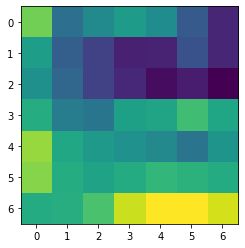

In [57]:
plt.imshow(torch.mean(x.view(x.size(0), x.size(1), -1), dim=0).cpu())

In [92]:
np.shape(img_map)

(480, 640)

In [86]:
img_map = torch.mean(x.view(x.size(0), x.size(1), -1), dim=0).cpu().numpy()
img_map = cv2.resize(img_map, (480,640))
np.shape(img_map)

(640, 480)

In [93]:
np.shape(image[:,:,0])

(480, 640)

In [102]:
img_map

array([[ 0.01473316,  0.01473316,  0.01473316, ..., -0.2790991 ,
        -0.2790991 , -0.2790991 ],
       [ 0.01473316,  0.01473316,  0.01473316, ..., -0.2790991 ,
        -0.2790991 , -0.2790991 ],
       [ 0.01473316,  0.01473316,  0.01473316, ..., -0.2790991 ,
        -0.2790991 , -0.2790991 ],
       ...,
       [-0.05979236, -0.05979236, -0.05979236, ...,  0.07981628,
         0.07981628,  0.07981628],
       [-0.05979236, -0.05979236, -0.05979236, ...,  0.07981628,
         0.07981628,  0.07981628],
       [-0.05979236, -0.05979236, -0.05979236, ...,  0.07981628,
         0.07981628,  0.07981628]], dtype=float32)

In [105]:
np.asarray(image[:,:,0]/255, dtype=np.float32)

array([[0.54901963, 0.5019608 , 0.48235294, ..., 0.2627451 , 0.24313726,
        0.30588236],
       [0.49019608, 0.47843137, 0.4       , ..., 0.36862746, 0.23137255,
        0.30588236],
       [0.42352942, 0.43137255, 0.32941177, ..., 0.27058825, 0.30588236,
        0.34509805],
       ...,
       [0.08235294, 0.08235294, 0.06666667, ..., 0.60784316, 0.60784316,
        0.61960787],
       [0.06666667, 0.08627451, 0.0627451 , ..., 0.6862745 , 0.68235296,
        0.63529414],
       [0.05490196, 0.08627451, 0.06666667, ..., 0.64705884, 0.6509804 ,
        0.627451  ]], dtype=float32)

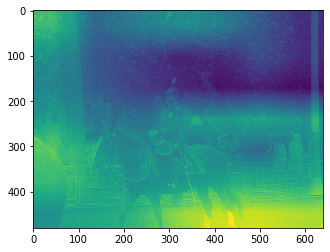

In [110]:
image = cv2.imread('input.jpg')
img_map = torch.mean(x.view(x.size(0), x.size(1), -1), dim=0).cpu().numpy()
img_map = cv2.resize(img_map, (640,480))
#plt.imshow(image)
plt.imshow(cv2.addWeighted(np.asarray(image[:,:,0]/255, dtype=np.float32), 0.1, img_map, 1, 0))


In [ ]:
plt.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

In [50]:
f = np.load('d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738.npy', allow_pickle=True)
f

array({'bbox': array([[4.07631439e+02, 1.39828284e+03, 1.03909656e+03, 1.57756677e+03],
       [2.77083984e+02, 1.20697913e+03, 9.49552856e+02, 1.61641040e+03],
       [4.90958899e-01, 6.54291570e-01, 6.18985116e-01, 2.11433500e-01],
       [5.05516663e+02, 1.38983667e+03, 1.03683765e+03, 1.50647351e+03],
       [1.82457007e+03, 1.46766174e+03, 2.12830127e+03, 1.55195605e+03],
       [1.83140222e+03, 1.23142017e+03, 2.13285815e+03, 1.43751953e+03],
       [2.36942783e-38, 2.36942783e-38, 2.36942783e-38, 2.36942783e-38],
       [5.63967102e+02, 7.73339294e+02, 1.04104907e+03, 1.51226575e+03],
       [1.08882814e-05, 9.99989152e-01, 6.33880518e-06, 9.99993682e-01],
       [2.23358814e-37, 2.23358814e-37, 2.23358814e-37, 2.23358814e-37],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.70079810e-03, 1.74508259e-05, 7.17977309e-05, 9.26219291e-05],
       [0.00000000e+00, 0.00000000e+

In [30]:
#not detected
import shutil
df = mimic_ap_pa_chexpert[mimic_ap_pa_chexpert['Pneumonia'] == -1].sample(frac=1.0).reset_index().head(1000)#get only first 1000
loc = os.path.join(os.getcwd(),'pneumonia_neg_1/')
for index, row in df.iterrows():
    dest = shutil.copyfile(row['path'], os.path.join(loc,row['dicom_id']+'.jpg'))

In [31]:
l = os.path.join(os.getcwd(), 'pneumonia_neg_1/')
neg_1_list = list(Path(l).rglob("*.jpg"))
neg_1_list = [str(x) for x in neg_1_list]
neg_1_list = pd.DataFrame(neg_1_list, columns=['path'])
neg_1_list['dicom_id'] = neg_1_list['path'].apply(lambda x: os.path.basename(x).split('.')[0])
pd.merge(mimic_ap_pa_chexpert, neg_1_list, on='dicom_id')

dicom_id  subject_id_x  study_id  \
0    6976b759-a3c21932-f5fed21a-f20c3a55-f6b2a31e      10009049  54850191   
1    6e58e826-fc08e4ee-a9ff0245-34c6f4cd-cd0aedc8      10013643  53841005   
2    13d1ff62-d27d8665-29104ffb-30bef639-12e8e978      10048001  57376621   
3    82900d83-b863df80-9ba040c7-3ab5ede4-63ca80fa      10049851  55477894   
4    a58cb9a4-1b0f64b3-1a719c69-4d2e7fce-3f2b4b38      10055694  54669448   
5    9aaa46a3-4c043a76-273685c9-997dd447-76a6b969      10057009  55685825   
6    2bc1faf8-e986c1c3-da21cf21-08d61b1e-47bd61a9      10064390  53483779   
7    c80f164d-1b147202-4cecfa75-5c4c6e8b-f2d019b9      10103748  59333384   
8    b5ab8839-b79120cf-bb127889-d34bc4f5-de45a950      10124825  51988497   
9    c9910900-9e6340d1-5bb4b3bc-ab0d02fb-92b46c70      10159585  55191283   
10   c53511d3-0d46f7df-c2d88d93-c6e33dd0-b837f780      10160202  52445408   
11   130227ee-cdb576ad-e5d85f50-4c5e42b5-90e3130f      10167784  56136145   
12   7b3334be-023d71b5-5c2db9dc-0783103f-fa9e7e49      10180204  58493841   
13   82364015-0a2da20e-e7b2c034-c415590c-2ab2f412      10185533  57321548   
14   a1baf819-3169be07-e46752dc-22f13ac7-b90bac22      10216153  56922439   
15   2ce66017-3a418b82-c673d143-c17f9967-6ba67a1d      10220107  54105393   
16   f5aa7580-16134543-a69f8621-f1737b66-97efed18      10232602  59832734   
17   591d52d5-af7780af-3dc513a0-544eb45c-ac3b8850      10240304  54032704   
18   a0113e6e-b5011a6c-671e86f8-70715bf1-f74d69bf      10246275  50639190   
19   6676b821-4a5a5ebb-42a9faed-1b2fbe7f-af6de151      10264902  55041187   
20   c4024f4c-92708457-d05d6f60-0f5fa899-745c9f49      10268311  56673756   
21   ced4bc5c-7508da2c-019b28bf-07603985-3946b7e7      10278322  55363833   
22   1bd2fd76-8b7184e7-e11450f6-db22419c-1bb2ac8e      10283452  58168674   
23   1971484a-7487aef1-6c260027-91afa1c0-f17e05e4      10287577  56505603   
24   33c9f9fc-de5813f2-45937a0b-667d714c-146fdfc5      10306412  54876602   
25   ed8864ef-63956ed9-ea5c274c-75121798-f84db476      10337403  56827733   
26   ff35fd66-7b1e6077-606a2201-8dffc170-e3ebc191      10352433  52030200   
27   4245b445-23c57944-c14a7768-21d3323e-6b329c9e      10362036  57425870   
28   43e6ccc5-36917b55-33ce39c3-16ec0464-3033d512      10364180  50309384   
29   a4e100c3-80d2073d-9645f3d5-fe18630a-d66c87f6      10365870  52033108   
..                                            ...           ...       ...   
970  925df8ba-c98b06d3-d56efc14-ba756be9-a03b5b86      19710521  51626392   
971  4d0b723e-81f94926-ed0f9dcc-7c84cb0f-d99d29af      19718654  51868634   
972  c0a270fd-e635e760-25105a1f-25fde453-b521148c      19720782  50799000   
973  82c1c97a-b5708e95-baa8ec84-c1237993-93b67d8b      19720782  53342490   
974  f48bd3a5-0ebc1747-3b1eefbb-1f662877-55b901cc      19721801  55527969   
975  81804d07-9ea99b4f-e3d5b3ce-68a261a8-f8e839ff      19731665  53672353   
976  c655764b-a45dc3cd-b0352fcf-f496ec60-32cdb429      19757720  54364406   
977  5db1ff54-6a22902f-51402f15-27dc7310-21a1183c      19757720  55489891   
978  17822f29-285cf7a7-9b6bf297-e707567e-afb2b91c      19763430  59460094   
979  4a9d9d4a-49b1d312-d68d686d-959ef402-1eea509b      19765086  58378954   
980  f66861d1-e733a4b6-09deccf4-e4dd184a-69521cf3      19778971  55830081   
981  ac20f0ba-0b68b4a4-1f5d6128-6bf12310-6ab05851      19797153  56818075   
982  1aba466b-d6287e77-10ddf1f6-8eb54512-dc62b9d5      19819996  52769278   
983  a9980f37-37acf17f-70236b0a-03bf98df-892dda12      19865241  58559968   
984  28e2a638-76586446-ebf380fa-26eae7bf-af6fbc3f      19902080  53248474   
985  247125c4-d3771619-d3f0f316-f696f8c7-c66bc0b7      19907884  55906329   
986  1e3d9c09-b4fa903a-08143fcf-bf5ee644-691ccd63      19911542  52515148   
987  49f4594e-14aac871-fe48482c-9f0d0f3d-99a87168      19921471  51799910   
988  99cee6c2-0967d1e5-39dd3ad3-1dbb8bb4-1774e25f      19923690  57900539   
989  0dbcbbb0-22608c56-a2781559-e8528769-a7d39cfb      19928728  55082622   
990  d7457ca0-a9a76b30-c55e23d6-8caf8

In [27]:
loc

'/gpfs/ysm/home/kl533/Lab/Transformers/transforming_embracement/pneumonia_neg_1'

In [71]:
'''import torch
torch.cuda.empty_cache()
def mimic_loader(img_df, report_df):
    outs = []
    for index, row in img_df.iterrows():
        torch.cuda.empty_cache()
        im = cv2.imread(str(row['path']))
        outputs = predictor(im)
        y = row['Pneumonia']
        #XYWH_ABS
        res = outputs['instances'].pred_boxes
        #instances = outputs['instances'].to("cpu")
        is_detected = 0
        if len(res) > 0:#has predictions
            is_detected = 1
            res = res.to("cpu").tensor.tolist()#to list
        else:
            continue
            #res = []
        if index % 500 == 0:
            print('At index: {}'.format(index))
        report_path = report_df[report_df['study_id'] == row['study_id']]['report_path'].values[0]
        report = open(report_path,'r').read()
        # dicom_id, bbox, detected_pneumonia, report, study_id
        outs.append([row['dicom_id'], res, is_detected, str(row['path']), report_path, report, row['study_id'], y])
    print('DONE!')
    return pd.DataFrame(outs, columns = ['dicom_id', 'bbox', 'is_detected', 'path', 'report_path', 'report', 'study_id', 'y'])

import time
tic = time.perf_counter()
outputs_df = mimic_loader(mimic_pnumonia.iloc[:500], reports_df)
toc = time.perf_counter()
print(f"took {toc - tic:0.4f} seconds")'''

In [88]:
'''#this is generic, we dont need to do this for non detected images
def save_img_origShape(df, loc):
    for index, row in df.iterrows():
        im = cv2.imread(str(row['path']))
        v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1)
        v = v.overlay_instances(boxes=row['bbox'], assigned_colors=['b', 'b', 'b', 'b', 'b','b', 'b', 'b', 'b', 'b','b', 'b', 'b', 'b', 'b','b', 'b', 'b', 'b', 'b',])#draw only bounding box in color
        cv2.imwrite(loc+row['dicom_id'] + '.jpg', v.get_image()[:, :, ::-1])
        if index > 50:
            break
            
#detected
loc = os.path.join(os.getcwd(),'RSNA_detected/')
save_img_origShape(outputs_df[outputs_df['is_detected'] == 1], loc)

#not detected
import shutil 
loc = os.path.join(os.getcwd(),'RSNA_not_detected/')
for index, row in outputs_df[outputs_df['is_detected'] == 0].iterrows():
    dest = shutil.copyfile(row['path'], loc+row['dicom_id']+'.jpg')
    
#detected without bounding boxes for feature extraction
import shutil 
loc = os.path.join(os.getcwd(),'FEATURE_EXTRACTION_TEST/')
for index, row in outputs_df[outputs_df['is_detected'] == 1].iterrows():
    dest = shutil.copyfile(row['path'], loc+row['dicom_id']+'.jpg')
    if index > 50:
        break'''

In [ ]:
'''#Visualize image with annotations
dpi = 150
plt.ioff()
for index, row in outputs_df.iterrows():
    im = cv2.imread(str(row['path']))
    height, width, channel = im.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1)
    v = v.overlay_instances(boxes=row['bbox'], assigned_colors=['b', 'b', 'b', 'b'])#draw only bounding box in color
    ax.imshow(v.get_image()[:, :, ::-1])
    ax.set(xlim=[-0.5, width - 0.5], ylim=[height - 0.5, -0.5], aspect=1)
    fig.savefig(row['dicom_id'] + '.jpg', dpi=dpi, transparent=True)
    break

    
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
#v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
v = v.overlay_instances(boxes=outputs["instances"].pred_boxes.to("cpu").tensor.tolist(), assigned_colors=['b', 'b', 'b', 'b'])#draw only bounding box in color
plt.figure(figsize = (15,15))
plt.imshow(v.get_image()[:, :, ::-1])
#plt.savefig(mimic_pnumonia.iloc[idx]['dicom_id'] + '_ANNOTATED.jpg')'''

In [ ]:
#Our setup to extract the features
'''#setup config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (pnumonia)
#Just run these lines if you have the trained model im memory
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
#build model
predictor = DefaultPredictor(cfg)
DetectionCheckpointer(predictor.model).load("output/model_final.pth")
predictor.model.eval()
#we have to PREPROCESS the tensor before partially executing it!
#taken from https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/defaults.py
#img = cv2.imread(outputs_df[outputs_df['is_detected'] == 1]['path'].iloc[0])
img = cv2.imread('FEATURE_EXTRACTION_TEST/121da9e6-50fb2afe-c8c1886c-e151708f-e167a824_ANNOTATED.jpg')
img = predictor.transform_gen.get_transform(img).apply_image(img)
img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1))
#img = np.transpose(img,(2,0,1))
#img = torch.from_numpy(img)
#img = ImageList.from_tensors([img], size_divisibility=32).to("cuda")
height, width = img.shape[:2]
inputs = {"image": img, "height": height, "width": width}
#taken from: https://github.com/facebookresearch/detectron2/blob/master/detectron2/modeling/meta_arch/rcnn.py
img = predictor.model.preprocess_image([inputs])
with torch.no_grad():#https://detectron2.readthedocs.io/_modules/detectron2/modeling/roi_heads/roi_heads.html : _forward_box()
    features = predictor.model.backbone(img.tensor)
    proposals, _ = predictor.model.proposal_generator(img, features, None)
    results, _ = predictor.model.roi_heads(img, features, proposals, None)
    instances = predictor.model.roi_heads._forward_box(features, proposals)
    proposal_boxes = [x.proposal_boxes for x in proposals]
    pred_boxes = [x.pred_boxes for x in instances]
    proposal_rois = predictor.model.roi_heads.box_pooler([features[f] for f in predictor.model.roi_heads.in_features], proposal_boxes)
    box_features = predictor.model.roi_heads.box_head(proposal_rois)
    predictions = predictor.model.roi_heads.box_predictor(box_features)#found here: https://detectron2.readthedocs.io/_modules/detectron2/modeling/roi_heads/roi_heads.html
    #WE CAN USE THE PREDICTION CLS TO FIND TOP SCOREING PROPOSAL BOXES!
    #predictor.model.roi_heads.box_predictor.test_topk_per_image = 1000
    #predictor.model.roi_heads.box_predictor.test_nms_thresh = 0.99
    #predictor.model.roi_heads.box_predictor.test_score_thresh = 0.0
    pred_instances, losses = predictor.model.roi_heads.box_predictor.inference(predictions, proposals)#something to do with: NMS threshold for prediction results. found: https://github.com/facebookresearch/detectron2/blob/master/detectron2/modeling/roi_heads/fast_rcnn.py#L460
'''